# Plotting Molecules and Cells

**Author**: Clarence Mah<br>
**Last Updated**: 6/6/2022

We will showcase the useful subcellular spatial capabilities of `bento` using the included seqFISH+ dataset.

```{tip}
There are several options available for visualization that are light wrappers building on their `seaborn` package counterparts. Using the `bento.pl.cellplot` function, you may create:
- **2D histogram (default)**: `kind = 'hist'`
        - [https://seaborn.pydata.org/generated/seaborn.histplot.html](https://seaborn.pydata.org/generated/seaborn.histplot.html)
- **Scatter plot**: `kind = 'scatter'`
    - [https://seaborn.pydata.org/generated/seaborn.scatterplot.html](https://seaborn.pydata.org/generated/seaborn.scatterplot.html)
- **Hexbin plots**: `kind = 'hex'`
    - [https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hexbin.html](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hexbin.html)
```

## Load Libraries

In [1]:
import bento

## Load Data

Let's use the seqFISH+ dataset.

In [2]:
adata = bento.datasets.load_dataset("seqfish")
adata

AnnData object with n_obs × n_vars = 179 × 3726
    obs: 'cell_shape', 'nucleus_shape', 'batch', 'cell_radius', 'nucleus_inner_edge_shape', 'cell_inner_edge_shape', 'nucleus_outer_edge_shape', 'n_detected', 'fraction_detected', 'cell_edge_count', 'cell_edge_fraction', 'cytoplasmic_count', 'cytoplasmic_fraction', 'nuclear_count', 'nuclear_fraction', 'nuclear_edge_count', 'nuclear_edge_fraction', 'none_count', 'none_fraction', 'td_cluster'
    var: 'n_detected', 'fraction_detected', 'cell_edge_count', 'cell_edge_fraction', 'cytoplasmic_count', 'cytoplasmic_fraction', 'nuclear_count', 'nuclear_fraction', 'nuclear_edge_count', 'nuclear_edge_fraction', 'none_count', 'none_fraction', 'td_cluster'
    uns: 'points', 'tensor', 'tensor_labels', 'tensor_loadings'
    layers: 'cell_edge', 'cell_edge_p', 'cell_inner_asymmetry', 'cell_inner_proximity', 'cell_outer_asymmetry', 'cell_outer_proximity', 'cytoplasmic', 'cytoplasmic_p', 'l_half_radius', 'l_max', 'l_max_gradient', 'l_min_gradient', 'l_mon

## Plot Molecule Densities

The default `cellplot` is a 2D histogram limited to the first field of view.

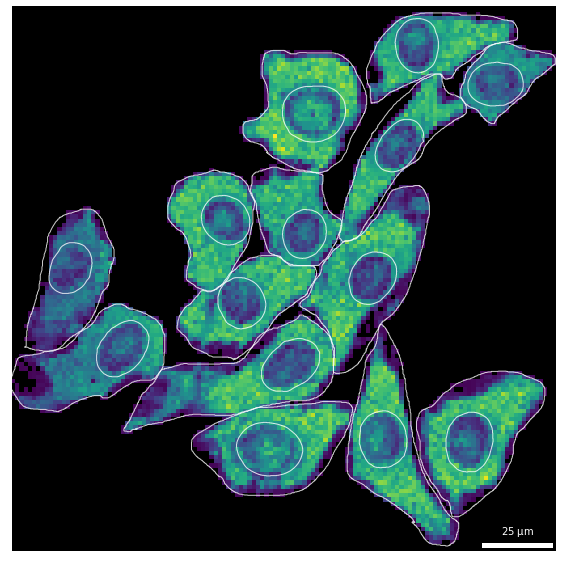

In [3]:
bento.pl.cellplot(adata)

### Hexbin

The RNA density can also be viewed as a `hexbin` plot. The colormap and other underlying parameters can be changed (see `matplotlib.pyplot.hexbin` for underlying parameters).

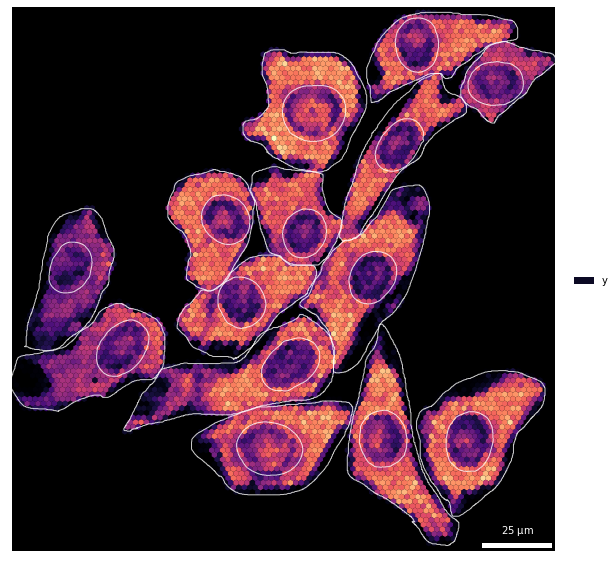

In [4]:
bento.pl.cellplot(adata, kind="hex", cmap="magma")

## Multiple Subplots

Multiple fields of view can be plotted at once by specifying `col="fov"`, as separate subplots. Field of view is annotated as a column (by default `"batch"`) in `adata.obs`.

  0%|          | 0/17 [00:00<?, ?it/s]

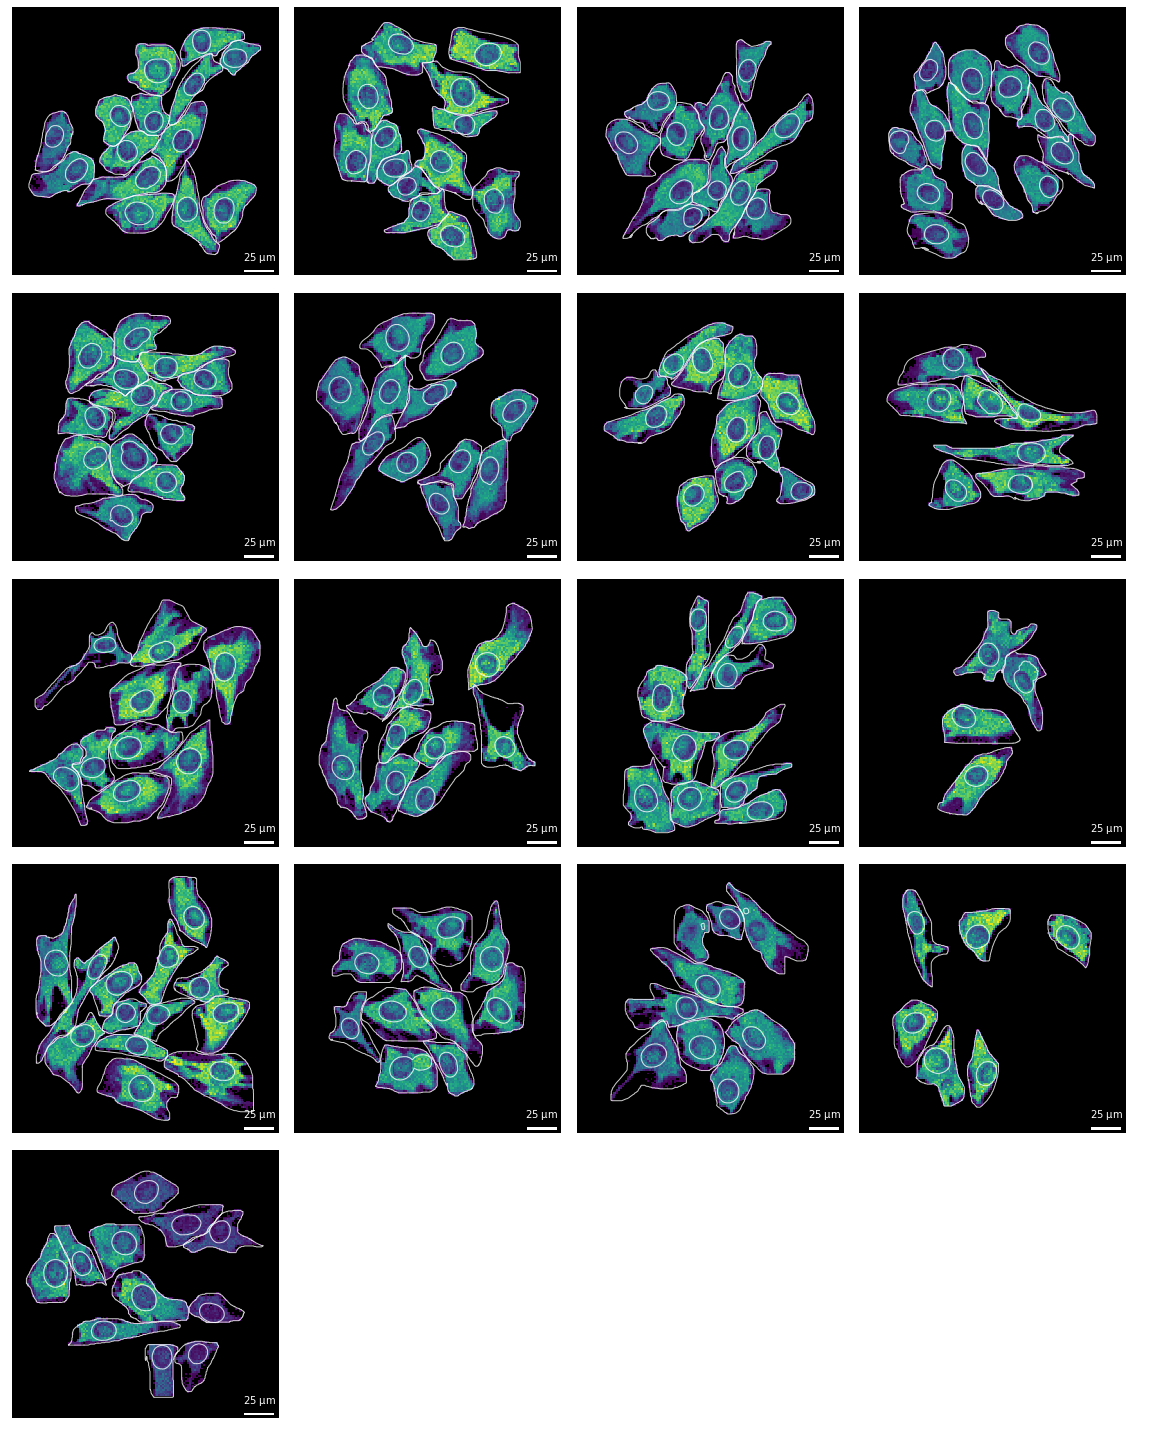

In [5]:
bento.pl.cellplot(adata, fovs="all", col="fov", col_wrap=4, height=4)

## Individual Molecules and Cells

Finally, we can plot specific cells and genes by subsetting and slicing the `adata` object. Here we set `kind="scatter"` for a scatterplot (see `sns.scatterplot` for additional parameters) and `hue="gene"` to color each gene uniquely.

In [6]:
# Randomly choose 10 genes from the top 100 most highly expressed genes
some_genes = adata.to_df().mean().sort_values().tail(50).sample(10).index.tolist()

  0%|          | 0/8 [00:00<?, ?it/s]

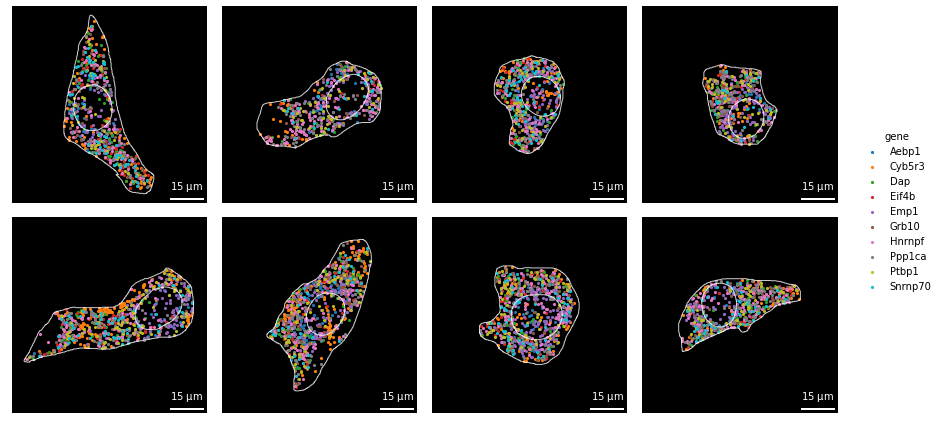

In [7]:
bento.pl.cellplot(
    adata[:8, some_genes],
    kind="scatter",
    hue="gene",
    col="cell",
    col_wrap=4,
    height=3,
    s=10,
)